In [1]:
from simulation.model import PathFindingModel
import mesa
import analytics.ranking_measures as measures
import pandas as pd

In [2]:
def group_summary(df, measure_func):
    group_statistics = {
        'zone':df['goal_zones'].iloc[0],
        'alg':df['path_planning_alg'].iloc[0],
        'goal_pop':df['intention_num'].iloc[0],
        'seed':df['seed'].iloc[0],
        'obstacle_used':df['obstacle_used'].iloc[0],
        'segments':df['segment_num'].max(),
        'segmentation':measure_func(df['Segment_ranking'],ground_truth_position=df['true_intention'].iloc[0]),
        'masters':measure_func(df['Masters_ranking'],ground_truth_position=df['true_intention'].iloc[0]),
        'mirroring':measure_func(df['Mirroring_ranking'],ground_truth_position=df['true_intention'].iloc[0])}
    return pd.Series(group_statistics)

def df_transform(raw_df, measure_func):
    run_statistics = raw_df.groupby('RunId').apply(lambda x: group_summary(x, measure_func))
    # run_statistics.set_index(['zone','goal_pop','seed','alg','obstacle_used'], inplace=True)
    return run_statistics

## Experiment 1: Justification of segmentation

In [4]:
params = {"width":20,"height":20,"obs_num":40,"goal_zones":['2,2,2,2,2,2,2','2,2,2,2','2,2'],"seed":range(0,30),"path_planning_alg":[0,1,2],"intention_profile":1}
results = mesa.batch_run(
    PathFindingModel,
    parameters = params,
    iterations = 1,
    max_steps = 500,
    number_processes = None,
    data_collection_period = 1,
    display_progress=True,
)
results_df_e1 = pd.DataFrame(results)

100%|██████████| 270/270 [14:50<00:00,  3.30s/it]


In [5]:
e1_fc = df_transform(results_df_e1, measures.final_correctness)
e1_fc_long = pd.melt(e1_fc.reset_index(), id_vars=['zone','alg','goal_pop','seed','obstacle_used','segments'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Final Correctness')
e1_fc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','segments','measure'], inplace=True)
e1_gc = df_transform(results_df_e1, measures.correctness)
e1_gc_long = pd.melt(e1_gc.reset_index(), id_vars=['zone','goal_pop','seed','alg','obstacle_used','segments'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='General Correctness')
e1_gc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','segments','measure'], inplace=True)
e1_cc = df_transform(results_df_e1, measures.last_change)
e1_cc_long = pd.melt(e1_cc.reset_index(), id_vars=['zone','goal_pop','seed','alg','obstacle_used','segments'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Convergence Correctness')
e1_cc_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','segments','measure'], inplace=True)
e1_stability = df_transform(results_df_e1, measures.stability)
e1_stability_long = pd.melt(e1_stability.reset_index(), id_vars=['zone','goal_pop','seed','alg','obstacle_used','segments'], value_vars=['segmentation','masters','mirroring'], var_name='measure', value_name='Stability')    
e1_stability_long.set_index(['zone','goal_pop','seed','alg','obstacle_used','segments','measure'], inplace=True)
e1 = pd.concat([e1_fc_long,e1_gc_long,e1_cc_long,e1_stability_long], axis=1)
e1.reset_index(names=['zone','goal_pop','seed','alg','obstacle_used','segments','measure'],inplace=True)
e1_long = pd.melt(e1, id_vars=['zone','goal_pop','seed','alg','obstacle_used','segments','measure'], value_vars=['Final Correctness','General Correctness','Convergence Correctness','Stability'], var_name='metric', value_name='value')

In [27]:
e1_long.to_csv('results/segmentation.csv')

In [6]:
e1_long.loc[e1_long['metric']=='Convergence Correctness','value'] = 1 - e1_long.loc[e1_long['metric']=='Convergence Correctness','value']

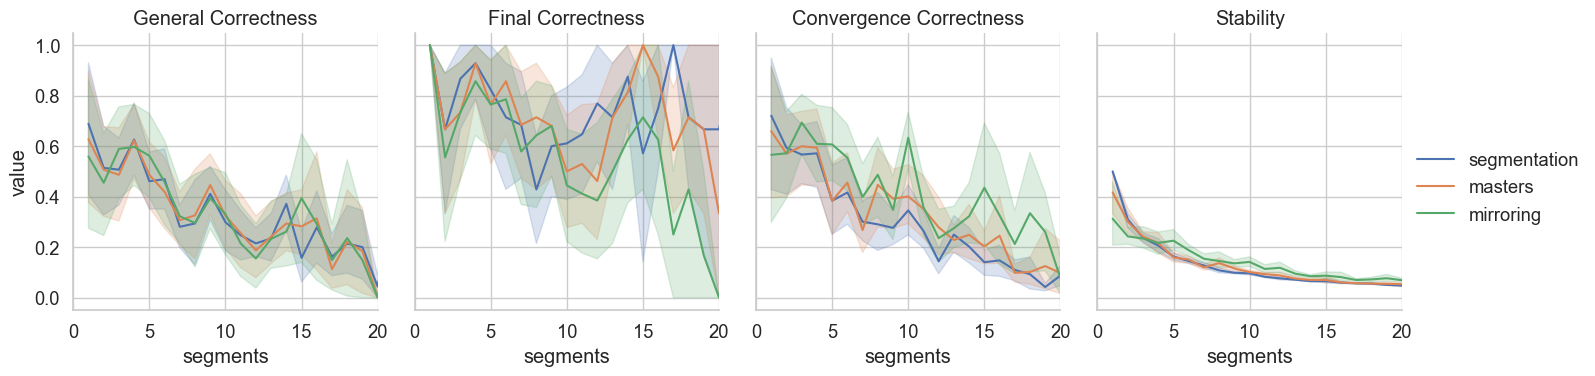

In [7]:
import seaborn as sns
sns.set(font_scale=1.2)
with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(e1_long, col="metric", height=4, aspect = 0.9, col_order=['General Correctness','Final Correctness','Convergence Correctness','Stability'], xlim=(0,20))
g.map(sns.lineplot,"segments", "value", "measure")
g.set_titles(col_template="{col_name}")
g.add_legend()

In [32]:
g.savefig('results/e4.pdf', format='pdf')